# Trading with Python and Binance - Introduction to the API

__Insert your Credentials here__:

In [ ]:
api_key = "insert_here"
secret_key = "insert_here"

## Installing required Libraries/Packages

For most Sections of this course, you should have installed: 
- Updated Anaconda Installation with Python Version 3.10 or higher
- lastest python-binance Version (1.0.19 or higher)

***Action required***: 

__1. If you haven´t updated Anaconda for a while, update with the command:__

conda update anaconda

__2a. Install python-binance__

pip install python-binance

__2b. In case you have installed python-binance a while ago, make sure you have the latest version installed:__

pip install python-binance --upgrade

## Creating a Connection

In [ ]:
from binance.client import Client

If you have an account on __Binance.com__ (non-US users)

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com")

In [ ]:
client

In [ ]:
client.get_account() # account details

If you have an account on __Binance.US__ (US residents) <br>
(If you are using an exchange from the US, Japan or other TLD then make sure pass tld=’us’ when creating the client.)


In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "us")

In [ ]:
client.get_account()  # account details

## General account/system Info

__Official API Documentation Site:__

https://binance-docs.github.io/apidocs/spot/en/#introduction

__API Wrapper (python-binance) Documentation Site:__

https://python-binance.readthedocs.io/en/latest/index.html

In [ ]:
import pandas as pd
from binance.client import Client

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com")

In [ ]:
client.ping() # Test connectivity 

In [ ]:
client.get_system_status()

In [ ]:
account = client.get_account()
account

In [ ]:
account["accountType"] # account Type (Spot, Futures)

In [ ]:
pd.to_datetime(account["updateTime"], unit = "ms") # Last Update -> UTC Time

In [ ]:
account["balances"] # asset balances

In [ ]:
df = pd.DataFrame(account["balances"])
df

In [ ]:
df.info()

In [ ]:
df.free = pd.to_numeric(df.free, errors="coerce")
df.locked = pd.to_numeric(df.locked, errors="coerce")

In [ ]:
df.loc[df.free > 0]

In [ ]:
client.get_asset_balance(asset = "BTC")

In [ ]:
client.get_asset_balance(asset = "ETH")

In [ ]:
float(client.get_asset_balance(asset="EUR")["free"]) 

In [ ]:
snap = client.get_account_snapshot(type = "SPOT") # daily account snapshot
snap

In [ ]:
snap = pd.json_normalize(snap["snapshotVos"])
snap

In [ ]:
snap.updateTime = pd.to_datetime(snap["updateTime"], unit = "ms") 

In [ ]:
snap

In [ ]:
snap["data.balances"][0]

In [ ]:
client.get_exchange_info()["rateLimits"] # API Limits

In [ ]:
client.get_all_coins_info() # asset/coin Info

In [ ]:
coins = pd.DataFrame(client.get_all_coins_info()) # asset/coin Info
coins

In [ ]:
coins.loc[coins.coin == "BTC"]

In [ ]:
coins.loc[coins.coin == "EUR"]

In [ ]:
client.get_trade_fee(symbol = "BTCUSDT")

In [ ]:
client.get_trade_fee(symbol = "BTCEUR")

In [ ]:
client.get_trade_fee(symbol = "BUSDUSDT") # zero commissions for stable coin pairs

In [ ]:
client.get_symbol_info(symbol = "BTCEUR") # information on symbol / pair

## Getting (current) Market Data

In [ ]:
from binance.client import Client
import pandas as pd

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com")

__Current Prices__

In [ ]:
client.get_symbol_ticker(symbol = "BTCUSDT") # current price for one symbol

In [ ]:
float(client.get_symbol_ticker(symbol = "BTCEUR")["price"])

In [ ]:
client.get_avg_price(symbol = "BTCUSDT") # current average price

In [ ]:
# get current prices for all pairs
prices = client.get_all_tickers()
prices

In [ ]:
df = pd.DataFrame(prices)
df

In [ ]:
df[df.symbol.str.contains("ETH")]

In [ ]:
df[df.symbol.str.contains("BTC") & df.symbol.str.contains("USD")]

In [ ]:
df[df.symbol.str.contains("BTC") & df.symbol.str.contains("EUR")]

In [ ]:
last24 = client.get_ticker(symbol = "BTCUSDT") # 24H Price change statistic
last24

In [ ]:
last24["openTime"]

In [ ]:
pd.to_datetime(last24["openTime"], unit = "ms") 

In [ ]:
pd.to_datetime(last24["closeTime"], unit = "ms") 

In [ ]:
open_price = float(last24["openPrice"])
open_price

In [ ]:
high_price = float(last24["highPrice"])
high_price

In [ ]:
low_price = float(last24["lowPrice"])
low_price

In [ ]:
close_price = float(last24["lastPrice"])
close_price

In [ ]:
close_price - open_price

In [ ]:
(close_price/open_price - 1) * 100

## Getting Historical Data (OHLC & Volume) - Part 1

In [ ]:
from binance.client import Client
import pandas as pd

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com")

In [ ]:
timestamp = client._get_earliest_valid_timestamp(symbol = "BTCUSDT", interval = "1d")
timestamp # earliest data available on Binance

In [ ]:
pd.to_datetime(timestamp, unit = "ms") # earliest data available on Binance

In [ ]:
bars = client.get_historical_klines(symbol = "BTCUSDT",
                                    interval = "1d", start_str = timestamp, limit = 1000)
bars

In [ ]:
df = pd.DataFrame(bars)
df

In [ ]:
df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")

In [ ]:
df

In [ ]:
df.columns = ["Open Time", "Open", "High", "Low", "Close",
              "Volume", "Clos Time", "Quote Asset Volume", 
              "Number of Trades", "Taker Buy Base Asset Volume",
              "Taker Buy Quote Asset Volume", "Ignore", "Date" ]

In [ ]:
df

In [ ]:
df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()

In [ ]:
df

In [ ]:
df.set_index("Date", inplace = True)

In [ ]:
df

In [ ]:
df.info()

In [ ]:
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors = "coerce")

## Getting Historical Data (OHLC & Volume) - Part 2

In [ ]:
def get_history(symbol, interval, start, end = None):
    bars = client.get_historical_klines(symbol = symbol, interval = interval,
                                        start_str = start, end_str = end, limit = 1000)
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Clos Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")
    
    return df

In [ ]:
timestamp

__Daily Data until Today/Now__

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1d", start = timestamp)
df

In [ ]:
df.info()

__Daily Data for specified Time Period__

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1d", start = "2021-01-01", end = "2021-06-30")
df

valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M

__Weekly Data for specified Time Period__

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1w", start = "2021-01-01", end = "2021-06-30")
df

__Monthly Data for specified Time Period__

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1M", start = "2021-01-01", end = "2021-06-15")
df

__Most recent Monthly Data (until today/now)__

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1M", start = "2021-01-01")
df

__Intraday Data (1H) for specified Time Period__

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1h", start = "2021-10-01", end = "2021-10-05")
df

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1h",
                 start = "2021-10-01 10:00:00", end = "2021-10-05 16:00:00")
df

__Intraday Data (1m) for specified Time Period__

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1m",
                 start = "2021-10-01 10:29:00", end = "2021-10-05 16:55:00")
df

__Most recent (last 2 hours) Intraday Data (1m)__

In [ ]:
from datetime import datetime, timedelta

In [ ]:
now = datetime.utcnow()
now

In [ ]:
two_hours_before = now - timedelta(hours = 2)
two_hours_before

In [ ]:
str(two_hours_before)

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1m", start = str(two_hours_before))
df

## Excursus: Loading Historical Data (csv) from the Website

In [ ]:
import pandas as pd

In [ ]:
url = r"C:\Users\hagma\OneDrive\Desktop\BTCUSDT-1h-2021-09\BTCUSDT-1h-2021-09.csv" # insert your filepath here
url

In [ ]:
df = pd.read_csv(url, header = None)
df

In [ ]:
df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
df

In [ ]:
df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Clos Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
df

In [ ]:
df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
df.set_index("Date", inplace = True)

#not required:
#for column in df.columns:
    #df[column] = pd.to_numeric(df[column], errors = "coerce")

In [ ]:
df

In [ ]:
df.info()

## Streaming Market Data (Part 1)

### ++++++ Update (August 2023) ++++++++

There are two alternatives to stream live data with python-binance:
- using __ThreadedWebsocketManager__ -or-
- using __BinanceSocketManager (newly added to the course)__

__ThreadedWebsocketManager:__ 
- Code is simpler
- worked with Python Version 3.7/3.8/3.9 __and__ python-binance Version <= 1.0.15 in __Jupyter Notebooks and Scripts__
- __no longer works in Juypter Notebooks__ if Python Version >= 3.10 __or__ python-binance Version > 1.0.15
- important: still works in any case in Python scripts!!! __-> We´ll use it in Scripts (later in the course).__

__BinanceSocketManager (NEW):__
- Code is more complex
- Works in Jupyter Notebooks and Scripts
- __We´ll use it here in Jupyter Notebooks as an executable alternative__

__What´s the benefit of covering both options?__<br>
-> We can now __run Trading Bots in Jupyter and as a Script__ with the __latest Versions__ for Python and Python-Binance. No need to care about Versions and Installations anymore!

----------------------------------------------------------------------

### Option 1: ThreadedWebsocketManager (only executable in scripts, not in Jupyter!):

In [ ]:
from binance import ThreadedWebsocketManager
import time

In [ ]:
def stream_data(msg):
    ''' define how to process incoming WebSocket messages '''
    print(msg)

In [ ]:
# initialize and start the WebSocket
twm = ThreadedWebsocketManager()
twm.start()

If you have an account on __Binance.US__ (US residents) <br>
(If you are using an exchange from the US, Japan or other TLD then make sure pass tld=’us’ when initializing the TWM.)

In [ ]:
# initialize and start the WebSocket in the us
# twm = ThreadedWebsocketManager(tld = "us")
# twm.start()

In [ ]:
twm

__Different Market Streams available:__ https://binance-docs.github.io/apidocs/spot/en/#websocket-market-streams

__Individual Symbol Mini Ticker:__ 24hr rolling window mini-ticker statistics. These are NOT the statistics of the UTC day, but a 24hr rolling window for the previous 24hrs.

In [ ]:
# subscribe to the stream
twm.start_symbol_miniticker_socket(callback = stream_data, symbol = "BTCUSDT")

In [ ]:
# stop the Websocket/Stream after 20 seconds
while True:
    time.sleep(20)
    twm.stop()
    break

__Individual Symbol Mini Ticker Output/Message:__

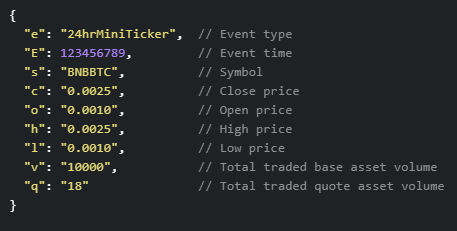

----------------------------------------------------

### Option2: BinanceSocketManager (executable in Jupyter!): 

In [ ]:
import asyncio
from binance import AsyncClient, BinanceSocketManager

In [ ]:
def stream_data(msg):
    ''' define how to process incoming WebSocket messages '''
    print(msg)

In [ ]:
async def main():
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client)
    ts = bm.symbol_miniticker_socket(symbol="BTCUSDT")
    
    async with ts as tscm:
        for _ in range(n):  # This is just an example to limit the number of messages. Remove or adjust as needed.
            res = await tscm.recv()
            stream_data(res)

    await client.close_connection()

In [ ]:
n = 10 # stop stream after 10 messages

In [ ]:
await main() # start stream in Jupyter

In [ ]:
# asyncio.run(main()) # start stream in Script!!!

If you have an account on __Binance.US__ (US residents) <br>
(If you are using an exchange from the US, Japan or other TLD then make sure pass tld=’us’ when initializing the client.)

In [ ]:
async def main():
    client = await AsyncClient.create(tld = "us")
    bm = BinanceSocketManager(client)
    ts = bm.symbol_miniticker_socket(symbol = "BTCUSD") # USD instead of USDT
    
    async with ts as tscm:
        for _ in range(n):  # This is just an example to limit the number of messages. Remove or adjust as needed.
            res = await tscm.recv()
            stream_data(res)

    await client.close_connection()

In [ ]:
await main()

## Streaming Market Data (Part 2)

### Option 1: ThreadedWebsocketManager (only executable in scripts, not in Jupyter!): 

In [ ]:
from binance import ThreadedWebsocketManager
import pandas as pd
import time

In [ ]:
# process data (not just printing)
def stream_data(msg):
    ''' define how to process incoming WebSocket messages '''
    
    time = pd.to_datetime(msg["E"], unit = "ms")
    price = msg["c"]
    
    print("Time: {} | Price: {}".format(time, price))

In [ ]:
twm = ThreadedWebsocketManager()
twm.start()

In [ ]:
twm.start_symbol_miniticker_socket(callback = stream_data, symbol = "BTCUSDT")

In [ ]:
while True:
    time.sleep(20)
    twm.stop()
    break 

-----------------------------------------------

### Option 2: BinanceSocketManager (executable in Jupyter!):

In [ ]:
stream_data

In [ ]:
import asyncio
from binance import AsyncClient, BinanceSocketManager
import pandas as pd

In [ ]:
async def main():
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client)
    ts = bm.symbol_miniticker_socket(symbol = "BTCUSDT")
    
    async with ts as tscm:
        for _ in range(10):
            res = await tscm.recv()
            stream_data(res)

    await client.close_connection()
await main()

## Streaming and Collecting Real-Time Candles

__Kline/Candlestick Stream:__ push updates to the current klines/candlestick every second.

https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-streams

__Output/Message:__

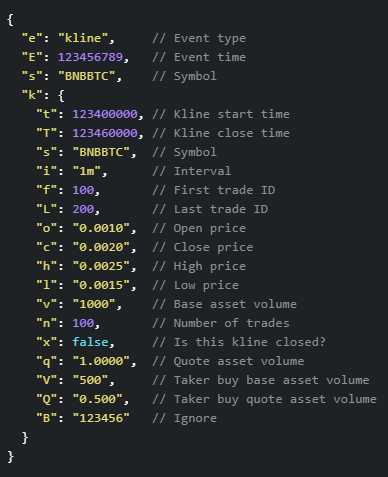

### Option 1: ThreadedWebsocketManager (only executable in scripts, not in Jupyter!):

In [ ]:
from binance import ThreadedWebsocketManager
import pandas as pd
import time

In [ ]:
df = pd.DataFrame(columns = ["Open", "High", "Low", "Close", "Volume", "Complete"])
df

In [ ]:
def stream_candles(msg):
    ''' define how to process incoming WebSocket messages '''
    
    # extract the required items from msg
    event_time = pd.to_datetime(msg["E"], unit = "ms")
    start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
    first   = float(msg["k"]["o"])
    high    = float(msg["k"]["h"])
    low     = float(msg["k"]["l"])
    close   = float(msg["k"]["c"])
    volume  = float(msg["k"]["v"])
    complete=       msg["k"]["x"]
    
    # print out
    print("Time: {} | Price: {}".format(event_time, close))
    
    # feed df (add new bar / update latest bar)
    df.loc[start_time] = [first, high, low, close, volume, complete]

In [ ]:
twm = ThreadedWebsocketManager()
twm.start()

valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M

In [ ]:
twm.start_kline_socket(callback = stream_candles, symbol = "BTCUSDT", interval = "1m")

In [ ]:
while True:
    time.sleep(120) # stop after 2 minutes
    twm.stop()
    break

In [ ]:
print(df)

----------------------------------------------

### Option 2: BinanceSocketManager (executable in Jupyter!): 

In [ ]:
import asyncio
from binance import AsyncClient, BinanceSocketManager
import pandas as pd

In [ ]:
df = pd.DataFrame(columns = ["Open", "High", "Low", "Close", "Volume", "Complete"])
df

In [ ]:
stream_candles

In [ ]:
async def main():
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client)
    ts = bm.kline_socket(symbol = "BTCUSDT", interval = "1m")
    
    async with ts as tscm:
        for _ in range(120):  # This is just an example to limit the number of messages. Remove or adjust as needed.
            res = await tscm.recv()
            stream_candles(res)

    await client.close_connection()
await main()

In [ ]:
df

In [ ]:
df.info()

## Creating a Test Order

In [ ]:
from binance.client import Client

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com")

In [ ]:
# place a test market buy order, to place an actual order use the create_order function
order = client.create_test_order(symbol = "BTCEUR", side = "BUY", type = "MARKET", quantity = 0.1)

In [ ]:
order

-> Paper Trading in the __Spot Testnet__ (see next Lectures)!!!